In [23]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions

from importlib import reload

%matplotlib inline

In [24]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_seconds = 86400

## Looking for ETVs in TIC 352830705 (Pair A)

- the ones with ~8d period
- Discussion at
  - https://www.zooniverse.org/projects/vbkostov/eclipsing-binary-patrol/talk/6324/3531040?comment=5800860&page=1


In [25]:
# define the plotting parameters

figsize = (8,4)

In [26]:
# import the data

# choose a TIC ID to analyze
ticid = 352830705

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC', 'QLP'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
with astropy.conf.set_temp("max_lines", -1):
    display(sr)
lcc_tess = sr.download_all()

def use_sap_flux(lc):
    """Helper over select_flux("sap_flux") to ensure flux_err is populated for QLP case"""
    if lc.meta.get("AUTHOR") == "QLP":
        # select_flux("sap_flux") on QLP data will lead to nan flux_err
        # because QLP lc only has err on kspsap_flux / det_flux
        return lc
    else:
        return lc.select_flux("sap_flux")
lc_tess = lcc_tess.stitch(
    # corrector_func=lambda lc: use_sap_flux(lc).normalize()
)
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 10 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 15 2019    QLP    1800   352830705      0.0         N/A
  1 TESS Sector 16 2019    QLP    1800   352830705      0.0         N/A
  2 TESS Sector 17 2019    QLP    1800   352830705      0.0         N/A
  3 TESS Sector 24 2020    QLP    1800   352830705      0.0         N/A
  4 TESS Sector 56 2022    QLP     200   352830705      0.0         N/A
  5 TESS Sector 57 2022    QLP     200   352830705      0.0         N/A
  6 TESS Sector 58 2022    QLP     200   352830705      0.0         N/A
  7 TESS Sector 76 2024    QLP     200   352830705      0.0         N/A
  8 TESS Sector 77 2024    QLP     200   352830705      0.0         N/A
  9 TESS Sector 78 2024    QLP     200   352830705      0.0         N/A

64434

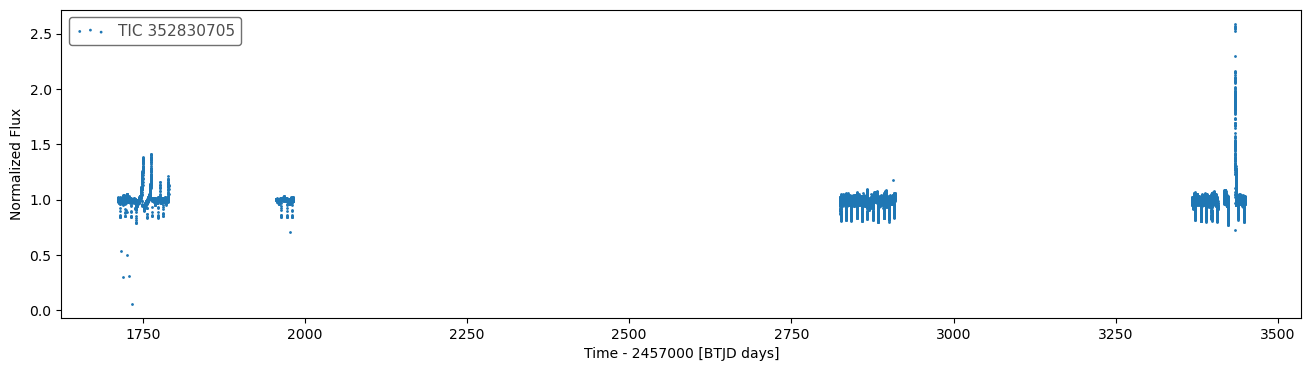

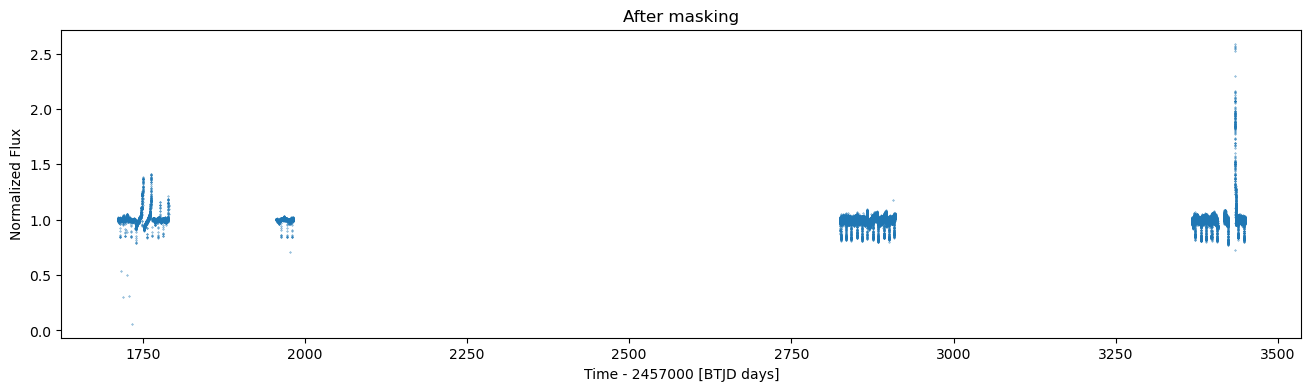

In [27]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=(figsize[0] * 2, figsize[1]))
search_result.scatter(ax = ax)

# TODO: mask out dips that are blended / or close to unrelated dips
mask = time < 0
# mask = mask | ( time > 1781) & (time < 1782)
# mask = mask | ( time > 1838) & (time < 1839)
# mask = mask | ( time > 1981.5) & (time < 1983)
# mask = mask | ( time > 2902) & (time < 2903)
# mask = mask | ( time > 3477.5) & (time < 3478.5)

# mask = flux < 0.85    # remove occasional outliers
# mask = (
#     ( flux < 0.95 ) | # remove occasional lone outliers
#     # cadences where scattered light effect is prevalent
#     ( (time > 2718)   & (time < 2744) )
# )

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=(figsize[0] * 2, figsize[1])).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [28]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [29]:
do_ls = False

if do_ls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg as lke_pg  # at ../../

    lc = lk.LightCurve(time=Time(time, format="btjd"), flux=flux, flux_err=fluxerr)
    lc.meta["LABEL"] = f"TIC {ticid}"
    pg = lc.to_periodogram(method="lombscargle",
                           # maximum_period=10,
                           # minimum_period=0.4,
                           # ls_method="fastchi2", nterms=2,
                           # oversample_factor=50,  # default: 5
                          )

    pg.show_properties();
    print(pg.period_at_max_power);

    ax = lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);

    ax = pg.plot(view="frequency");  # frequency view
    ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 10);

    ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");

    axs, lcs = lke_pg.plot_lc_with_model(
        lc,
        pg,
        plot_lc=False, plot_model=False, plot_folded_model=True,
        also_return_lcs=True);


In [30]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

### Define epoch, period, duration

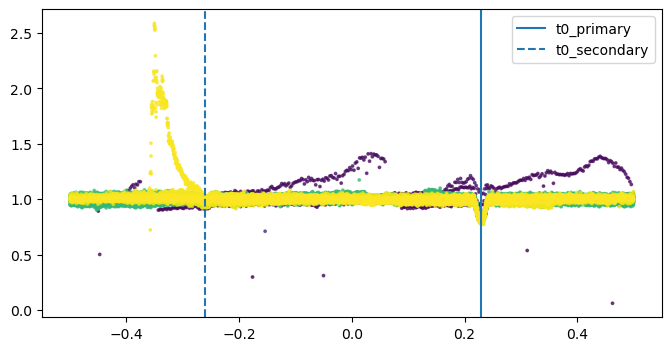

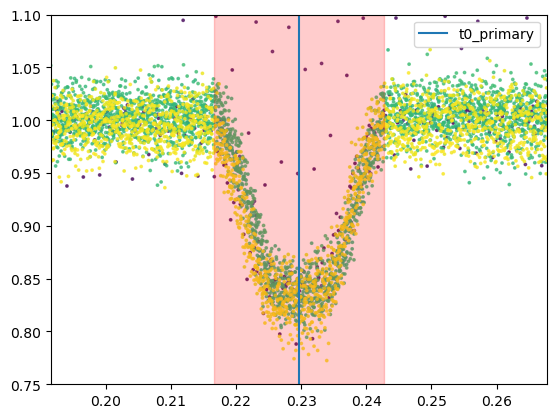

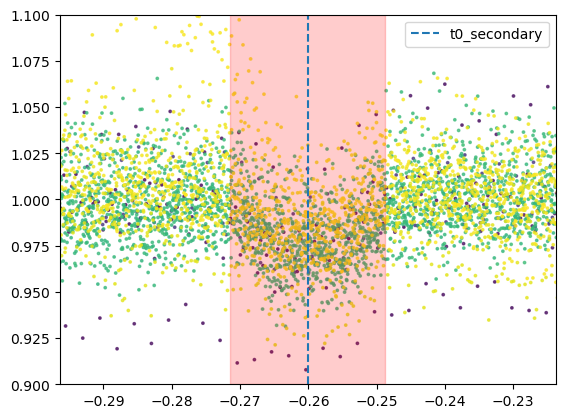

In [42]:
%matplotlib inline
# %matplotlib widget

# define the orbital period and the t0

# MCMC on df_primary: p=8.289721424206654, std_p: 2.356682635286e-06 ; t0=1714.980752679247,, std_t0: 0.0003378734002025498

# FILL-IN THE eclipse epoch / period,
# period = 8.289748  # from Veselin
period = 8.28972   # MCMC

# t0_primary = 1714.97  # eyeball
t0_primary = 1714.98  # MCMC
t0_secondary = 1719.21 # eyeball

duration_hr_primary = 5.2
duration_hr_secondary = 4.5

# ignore secondary for now
# t0_secondary = 1719.21
# duration_hr_secondary = 4.5

# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
plt.ylim(0.75, 1.1);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    plt.ylim(0.9, 1.1);
    plt.show()

### Compare folded plots across sectors

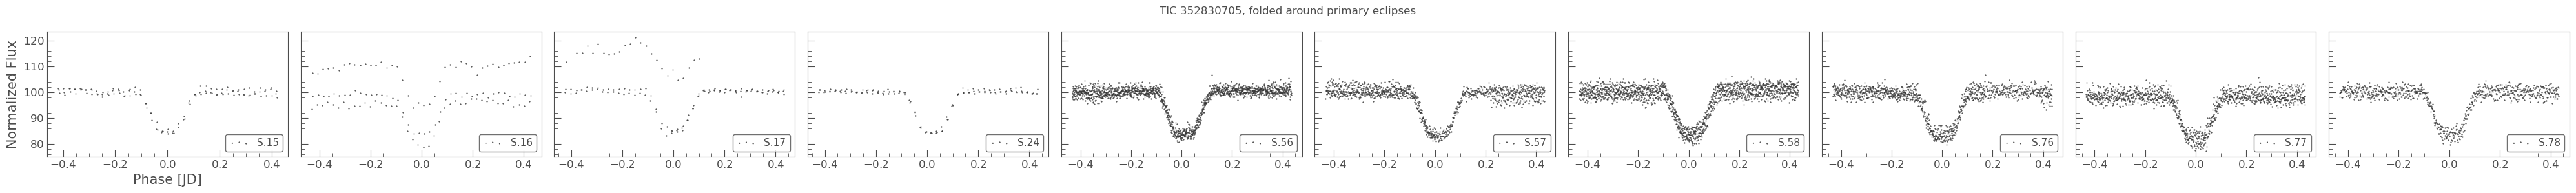

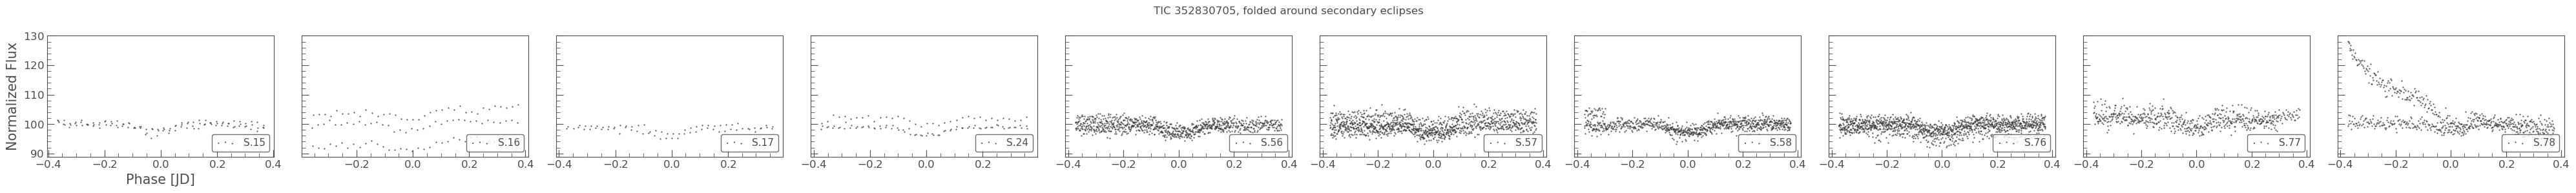

In [32]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0:
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [33]:
# show data to visualize what's changed in each step below
data

time      flux       err     phase
0      1711.384817  1.007575  0.006586 -0.202320
1      1711.405651  1.006582  0.006586 -0.199807
2      1711.426485  1.007415  0.006586 -0.197294
3      1711.447319  1.006773  0.006586 -0.194780
4      1711.468153  1.019929  0.006586 -0.192267
...            ...       ...       ...       ...
64345  3449.497777  0.993219  0.014067  0.467860
64346  3449.500092  1.006991  0.014067  0.468140
64347  3449.502407  0.997731  0.014067  0.468419
64348  3449.504722  1.003137  0.014067  0.468698
64349  3449.507037  0.978592  0.014067  0.468977

[64350 rows x 4 columns]

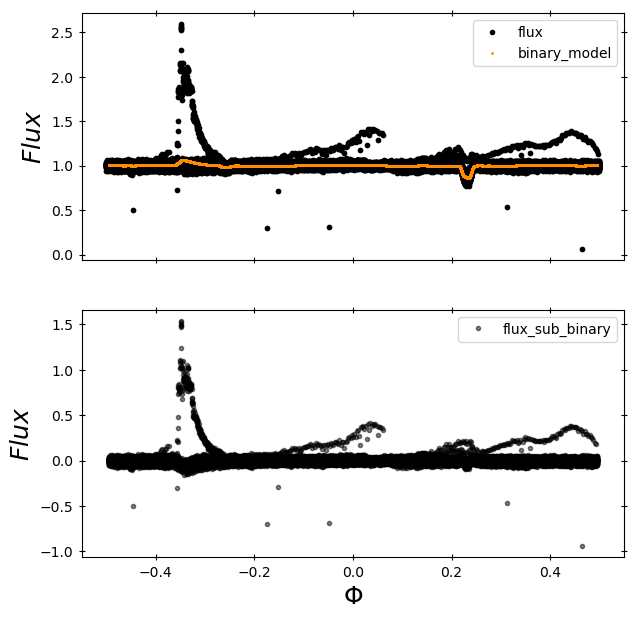

time      flux       err     phase  flux_sub_binary  \
0      1711.384817  1.007575  0.006586 -0.202320         0.010523   
1      1711.405651  1.006582  0.006586 -0.199807         0.009237   
2      1711.426485  1.007415  0.006586 -0.197294         0.009739   
3      1711.447319  1.006773  0.006586 -0.194780         0.008844   
4      1711.468153  1.019929  0.006586 -0.192267         0.021797   
...            ...       ...       ...       ...              ...   
64345  3449.497777  0.993219  0.014067  0.467860        -0.007452   
64346  3449.500092  1.006991  0.014067  0.468140         0.006266   
64347  3449.502407  0.997731  0.014067  0.468419        -0.003051   
64348  3449.504722  1.003137  0.014067  0.468698         0.002295   
64349  3449.507037  0.978592  0.014067  0.468977        -0.022312   

       binary_model  
0          0.997052  
1          0.997345  
2          0.997676  
3          0.997929  
4          0.998132  
...             ...  
64345      1.000672  
64346      1.000725  
64347      1.000782  
64348      1.000842  
64349      1.000903  

[64350 rows x 6 columns]

In [34]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 63766 901
reached the end
10 61414 901
reached the end
10 60993 901
reached the end
10 60924 901
reached the end
10 60909 901
reached the end


time      flux       err     phase  flux_sub_binary  \
0      1711.384817  1.007575  0.006586 -0.202320         0.010523   
1      1711.405651  1.006582  0.006586 -0.199807         0.009237   
2      1711.426485  1.007415  0.006586 -0.197294         0.009739   
3      1711.447319  1.006773  0.006586 -0.194780         0.008844   
4      1711.468153  1.019929  0.006586 -0.192267         0.021797   
...            ...       ...       ...       ...              ...   
64345  3449.497777  0.993219  0.014067  0.467860        -0.007452   
64346  3449.500092  1.006991  0.014067  0.468140         0.006266   
64347  3449.502407  0.997731  0.014067  0.468419        -0.003051   
64348  3449.504722  1.003137  0.014067  0.468698         0.002295   
64349  3449.507037  0.978592  0.014067  0.468977        -0.022312   

       binary_model  flux_detrended  
0          0.997052        0.996405  
1          0.997345        0.995457  
2          0.997676        0.996333  
3          0.997929        0.995740  
4          0.998132        1.008944  
...             ...             ...  
64345      1.000672        0.998137  
64346      1.000725        1.011924  
64347      1.000782        1.002664  
64348      1.000842        1.008069  
64349      1.000903        0.983539  

[64350 rows x 7 columns]

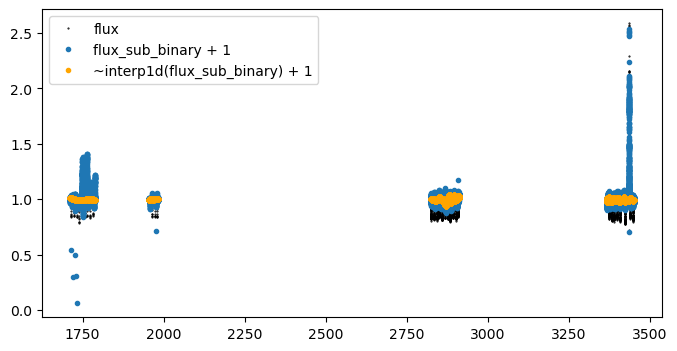

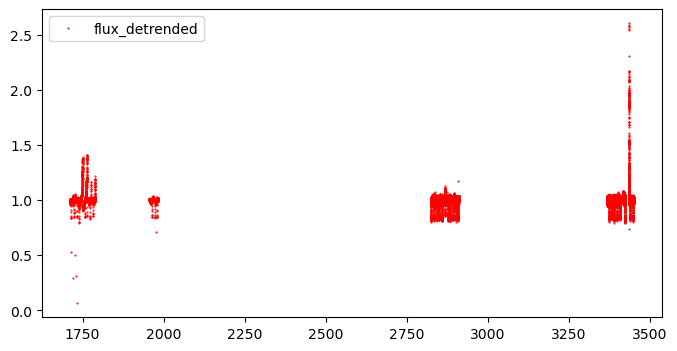

In [35]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

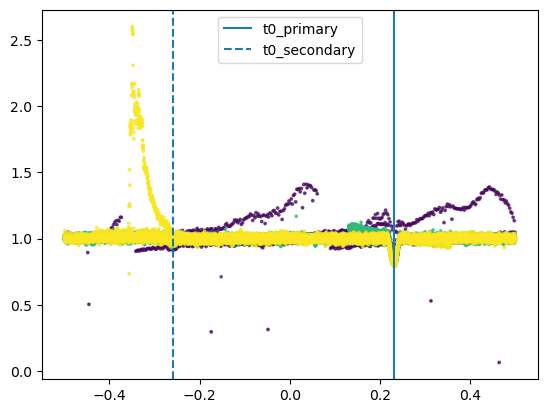

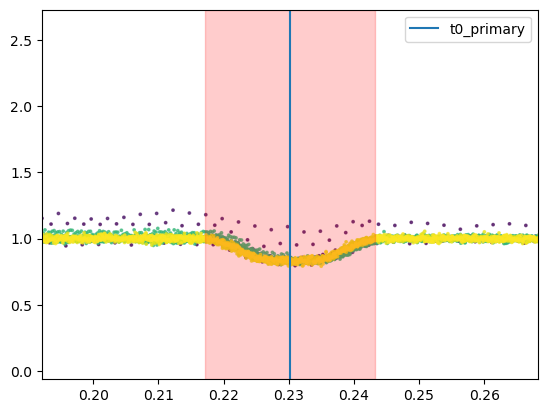

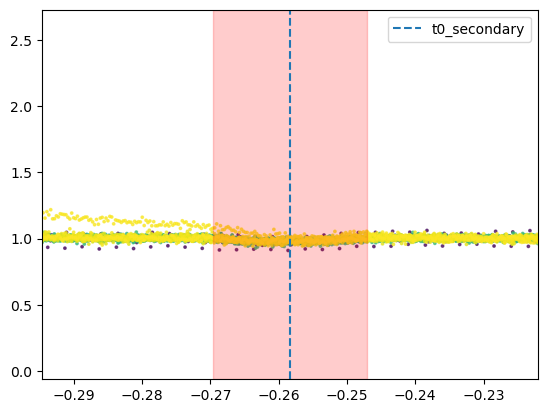

In [36]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

In [43]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 0.9 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 0.9 * duration_hr_secondary / 24 / period
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)

    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V)
# t0 in normalixed phase
start_vals = [1.013, -0.1696, midpoint_p, 0.00597, 1.835]
start_vals_s = [1.0, -0.025, midpoint_s, 0.005, 2.0]

# -- -- -- -- -- -- -- -- --
# etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess_interactive(data_primary, ph_binned, flux_binned, err_binned, "midpoint_p", *start_vals)
if t0_secondary is not None:
    # etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)
    etv_functions.plot_initial_guess_interactive(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, "midpoint_s", *start_vals_s)

print("Start params for  fitting period with MCMC on df_primary:")
print(f"[{start_vals[0]}, {start_vals[1]}, {t0_primary}, {start_vals[3]}, {start_vals[4]}, {period}],");

Primary:   1714.98 0.22962174838232108
window_width_p (phase): 0.023523110551381714
Secondary: 1719.21 -0.2601076996569351
window_width_s (phase): 0.020356537977157245


Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Output(layout=Layout(padding='1em 0px'))

Output(layout=Layout(padding='1em'))

Start params for  fitting period with MCMC on df_primary:
[1.013, -0.1696, 1714.98, 0.00597, 1.835, 8.28972],


In [38]:
if False:
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:07<00:00, 14.71it/s]


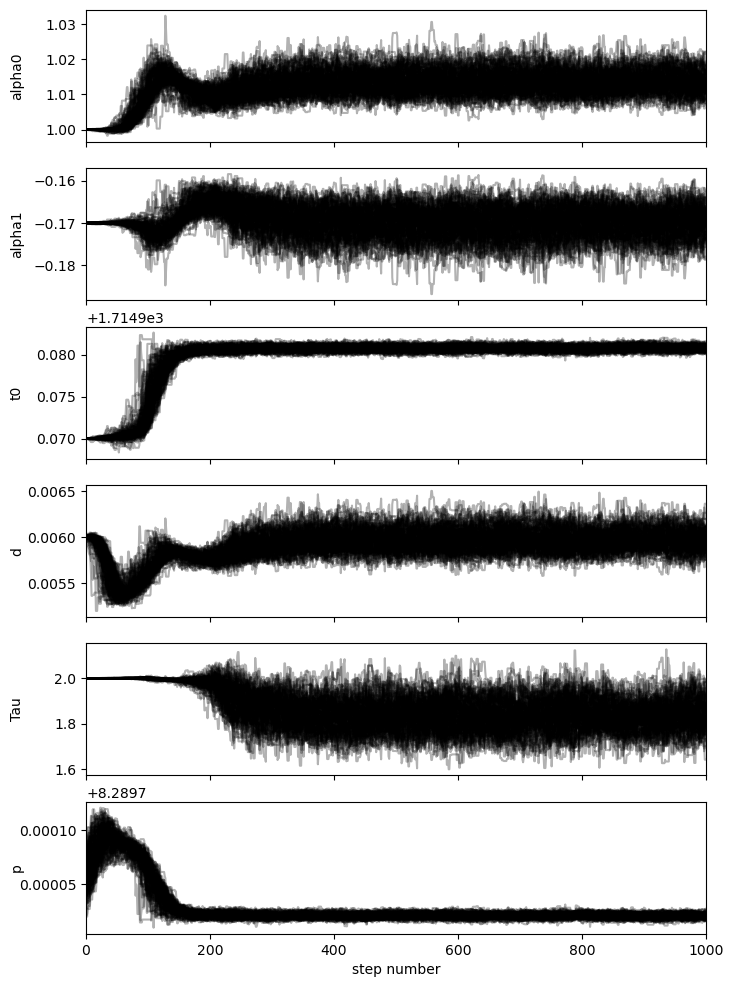

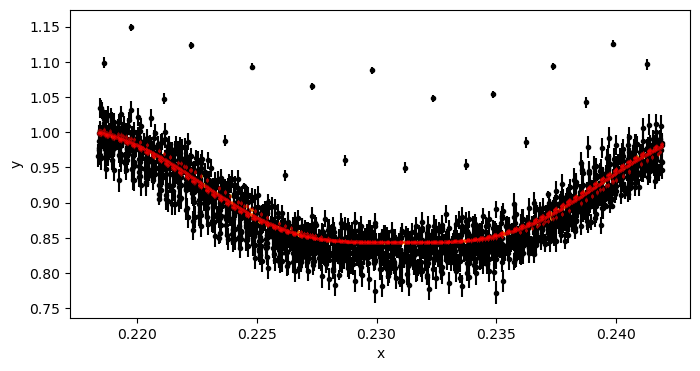

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0134031212606092, -0.16955066894922904, 1714.980752679247, 0.005965127450829723, 1.8350536458452091, 8.289721424206654
std_p: 2.356682635286e-06 ; std_t0: 0.0003378734002025498


In [41]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()

    # MCMC result
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.0, -0.17, 1714.97, 0.006, 2.0, 8.289748],
        # nruns=20, discard=1, # for a sanity test,  to ensure the initial guess is not way off.
        nruns=1000, discard=600,
        pool=-2,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"], "; std_t0:", fit_params_p_stats['std_t0'])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.42it/s]


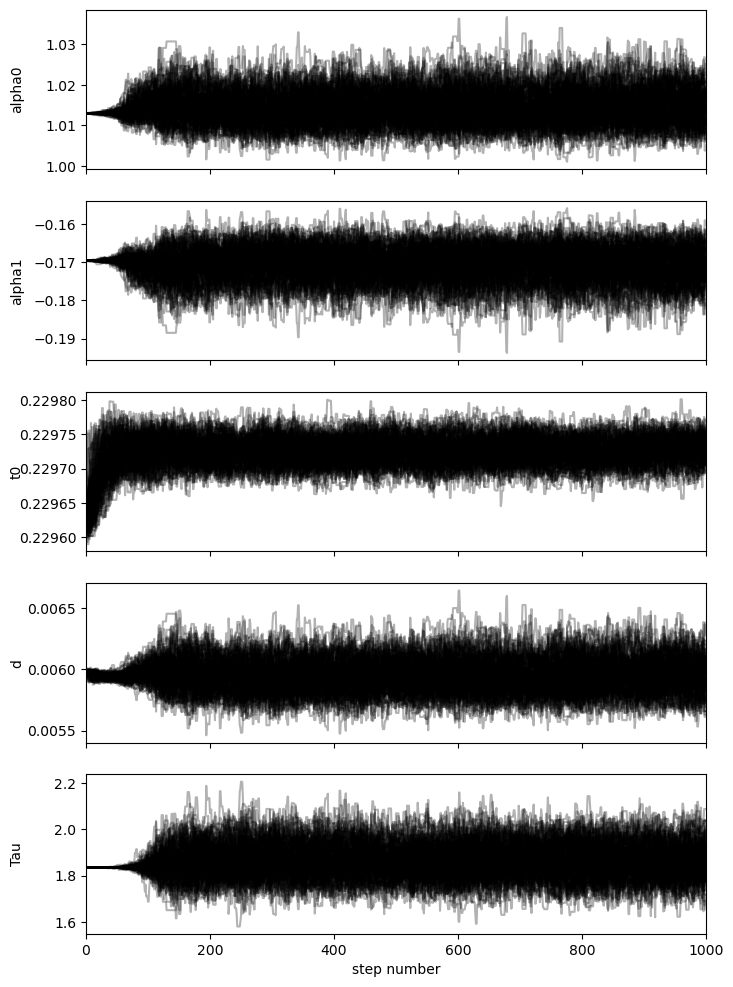

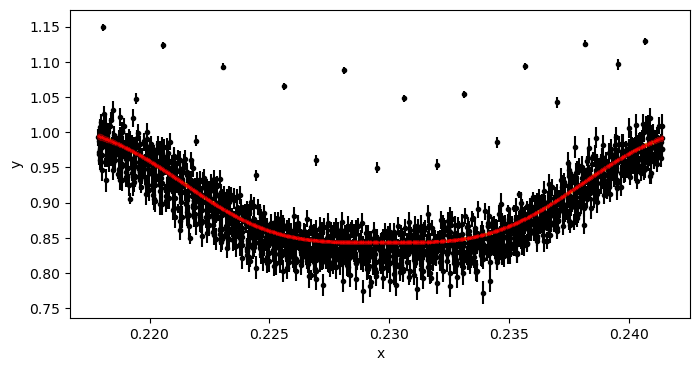

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.40it/s]


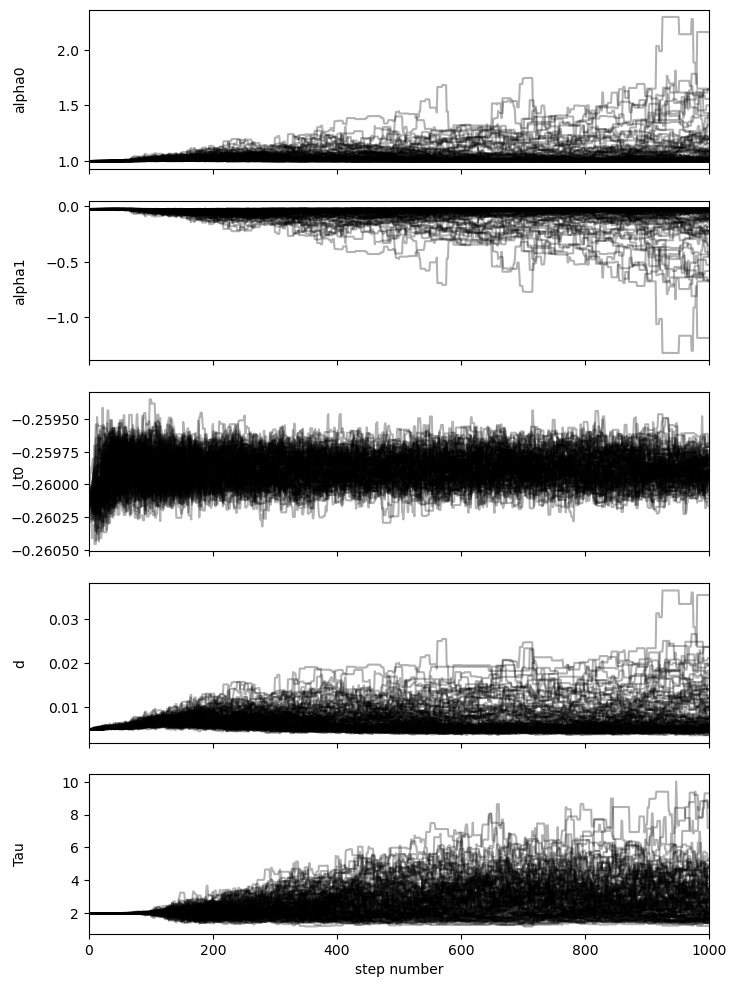

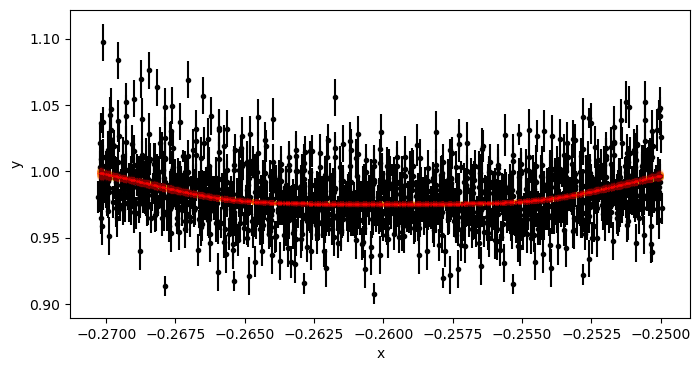

In [45]:
# run the initial model fit using MCMC for the primary and secondary eclipses
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=1000, discard=600, pool=-2, plot_chains = True, plot = True)
    !$NOTIFY_CMD "Initial fit done"

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 2000/2000 [01:43<00:00, 19.25it/s]


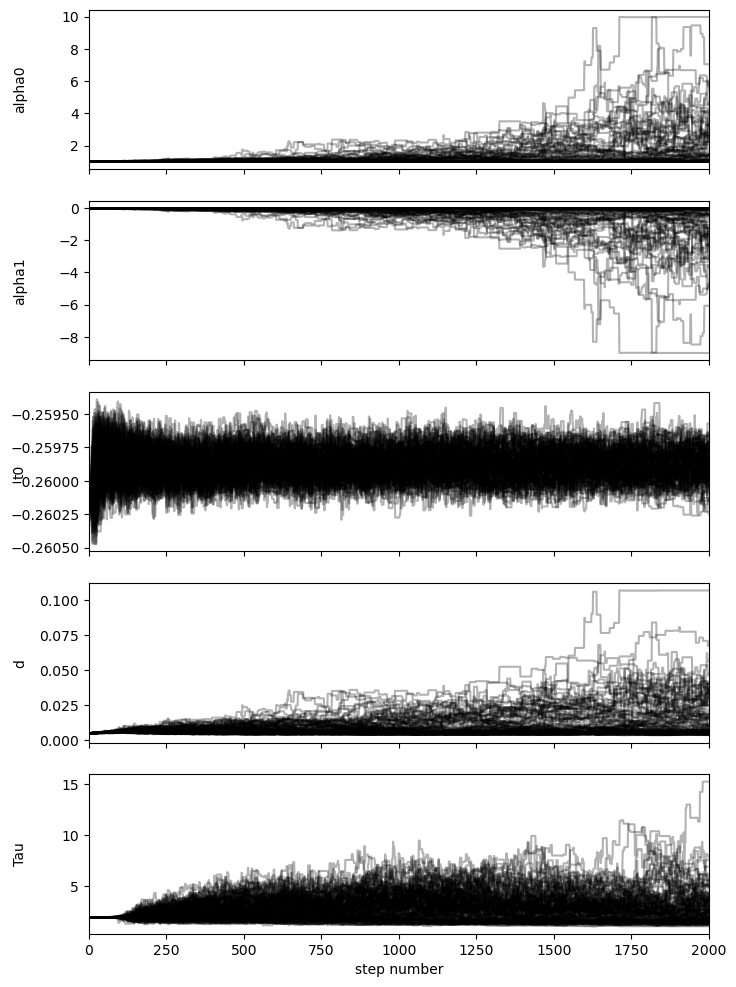

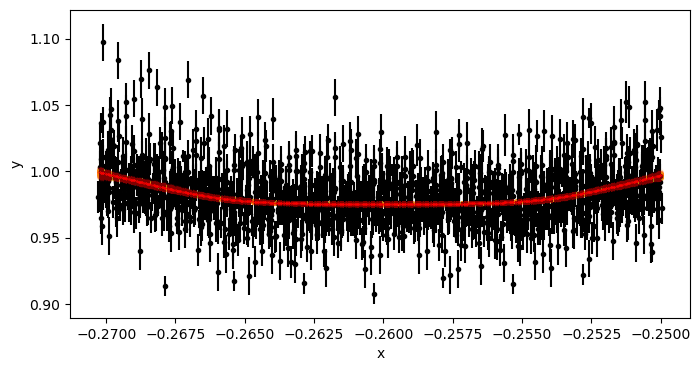

In [49]:
# Re-run secondary with a longer run, as it does not converge well
if run_init_fit:
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns=2000, discard=1000, pool=-2, plot_chains = True, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data (window od duration * 0.9]
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0142945653741924, -0.170343242318729, 0.2297263244504263, 0.005940556510642778, 1.8668175272327896
    # longer run, nruns=2000, still does not converge well
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0102247011915213, -0.034652007569601476, -0.25988135709880167, 0.005936678445415506, 2.4822916943190467  

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])

In [50]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0142945653741924, -0.170343242318729, 0.2297263244504263, 0.005940556510642778, 1.8668175272327896
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0102247011915213, -0.034652007569601476, -0.25988135709880167, 0.005936678445415506, 2.4822916943190467


209

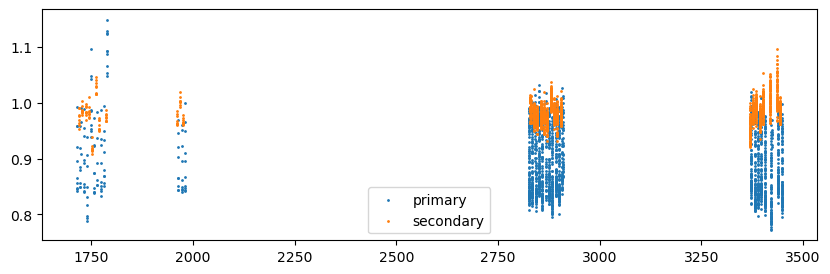

In [51]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1714.98 8.28972 1714.98


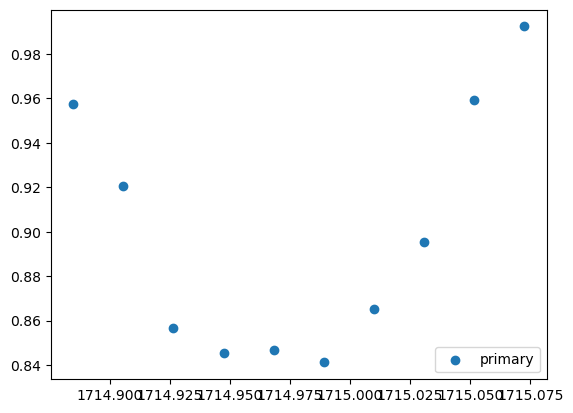

1714.98 8.28972 1723.26972


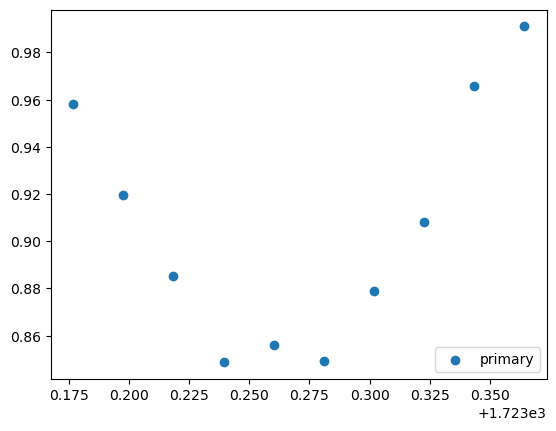

1714.98 8.28972 1731.55944


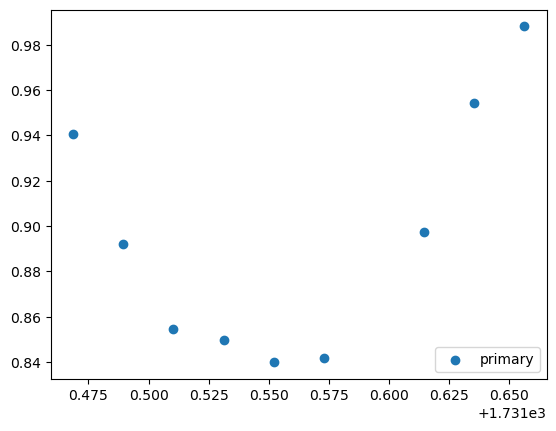

1719.21 8.28972 1719.21


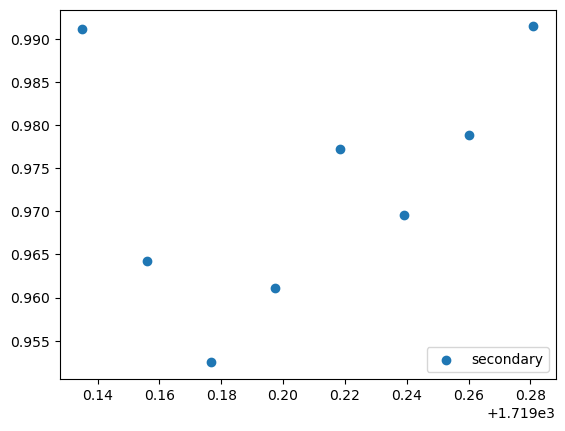

1719.21 8.28972 1727.49972


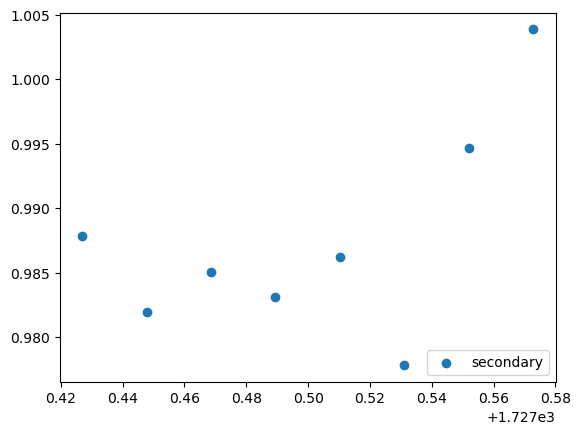

1719.21 8.28972 1735.78944


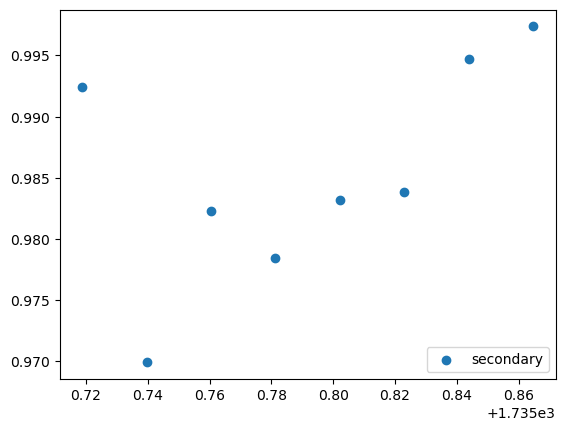

In [52]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux)
    yerr = np.array(data_primary.err)

    print (t0_primary, period, transit_time)

    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

    x = np.array(x[mask])
    y = np.array(y[mask])
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()


if t0_secondary is not None:
    for i in tr_index[0:3]:
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux)
        yerr = np.array(data_secondary.err)

        print (t0_secondary, period, transit_time)

        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period)))

        x = np.array(x[mask])
        y = np.array(y[mask])
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

### Fit individual eclipses

In [53]:
# Provide a warning if the expected number of data points per clipped LC is smaller than the default minimum `min_number_data` (20)
longest_cadence = np.max(sr.exptime)
est_number_data_primary   = int(duration_hr_primary / longest_cadence.to(u.hr).value)
print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) for primary: {est_number_data_primary}")
if est_number_data_primary < 20:
    display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (primary) < 20"))

if t0_secondary is not None:
    est_number_data_secondary = int(duration_hr_secondary / longest_cadence.to(u.hr).value)
    print(f"Expected num of data points of a clipped LC in longest cadence ({longest_cadence}) for secondary:  {est_number_data_secondary}")
    if est_number_data_secondary < 20:
        display(HTML("<span style='background-color: rgba(255, 0, 0, 0.7); padding-left: 1ch; padding-right: 1ch;'>WARN:</span> num of data points for a clipped LC (secondary) < 20"))

Expected num of data points of a clipped LC in longest cadence (1800.0 s) for primary: 10


Expected num of data points of a clipped LC in longest cadence (1800.0 s) for secondary:  9


Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
1723.26972 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.80it/s]


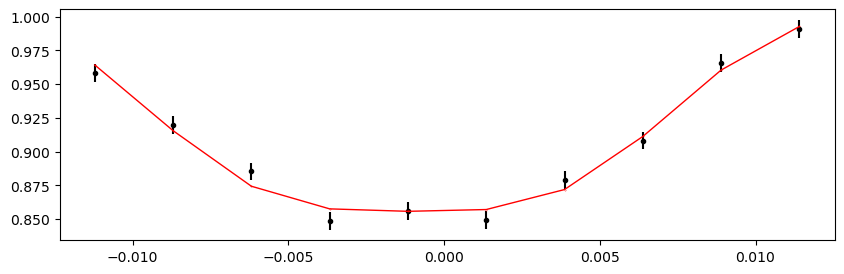

1731.55944 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.58it/s]


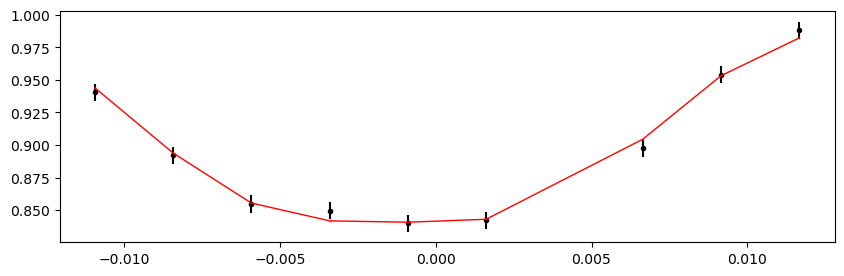

1739.84916 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 434.54it/s]


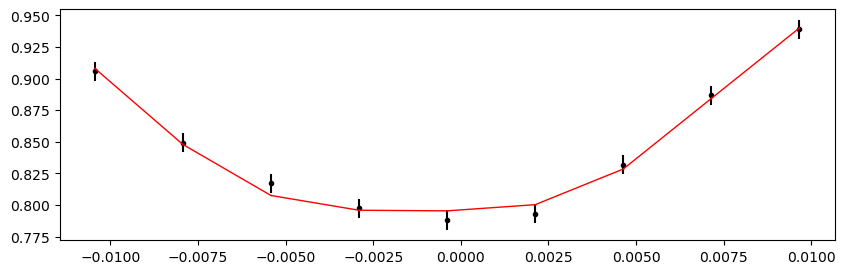

1748.13888 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 537.43it/s]


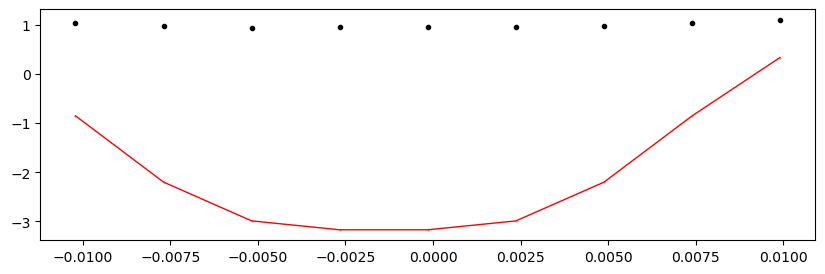

1756.4286 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.16it/s]


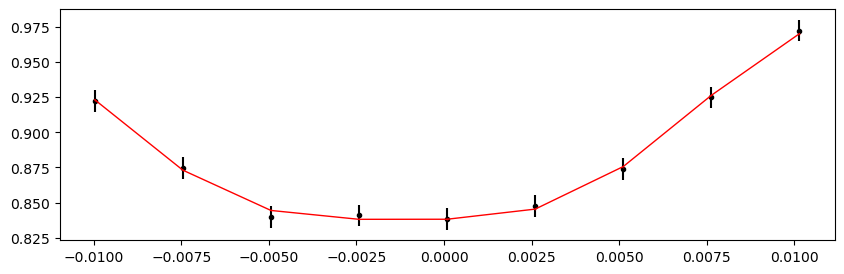

Time 1764.71832 does not have enough data points: 6
1773.00804 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 436.08it/s]


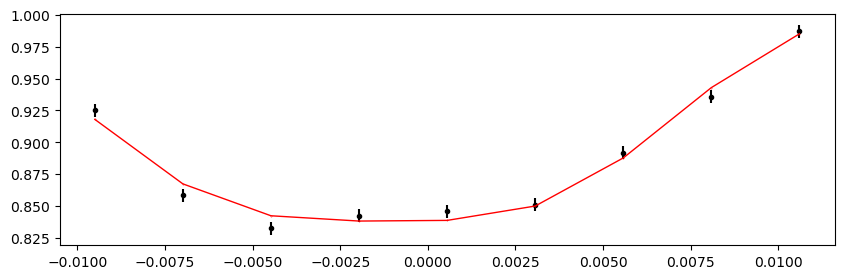

1781.29776 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 433.80it/s]


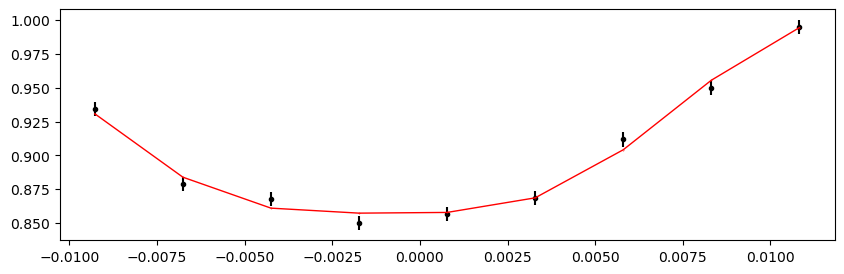

1789.5874800000001 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 536.12it/s]


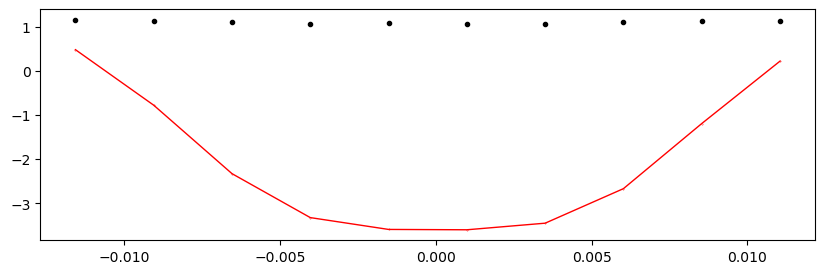

1963.6716000000001 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.35it/s]


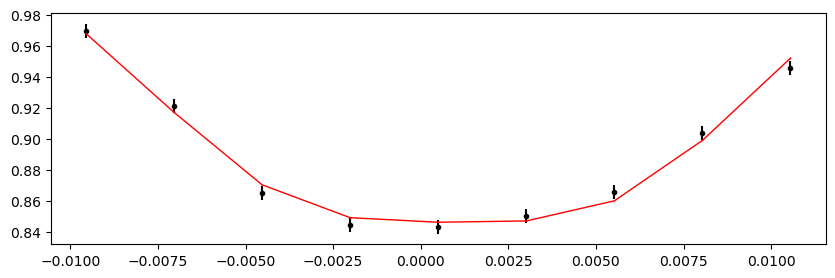

1971.9613200000001 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.72it/s]


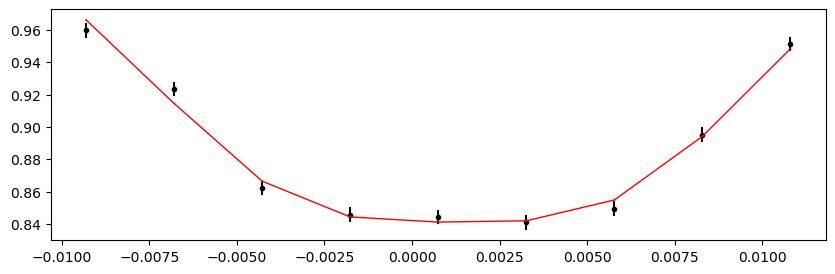

1980.25104 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.52it/s]


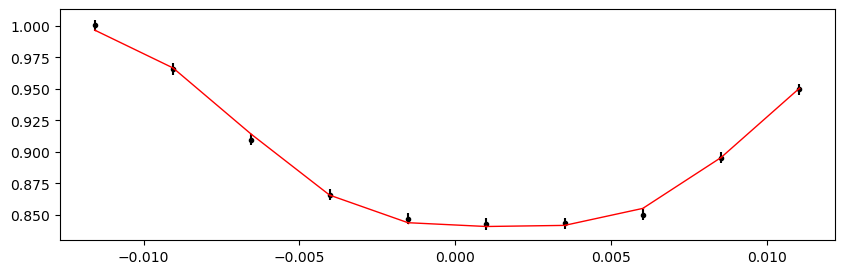

2825.8024800000003 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.95it/s]


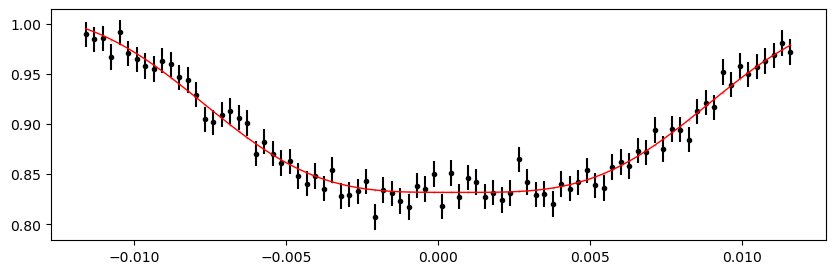

2834.0922 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 377.16it/s]


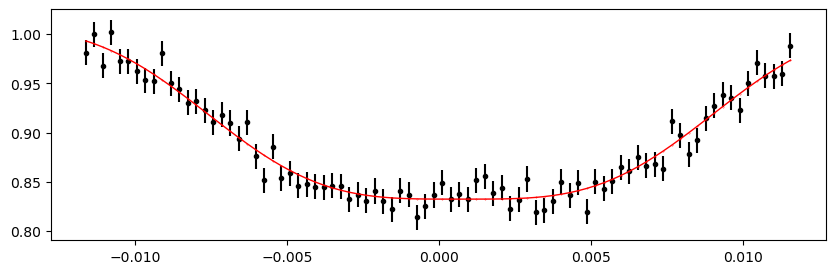

2842.38192 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 334.73it/s]


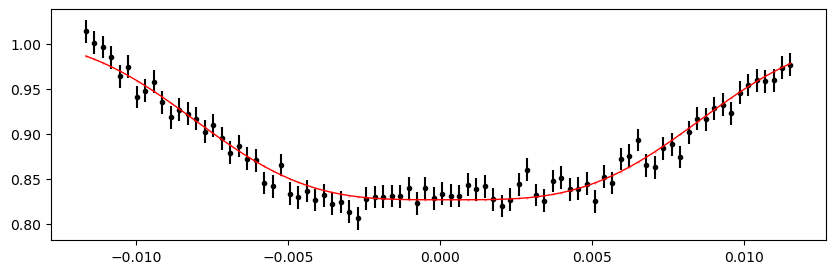

2850.67164 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 382.85it/s]


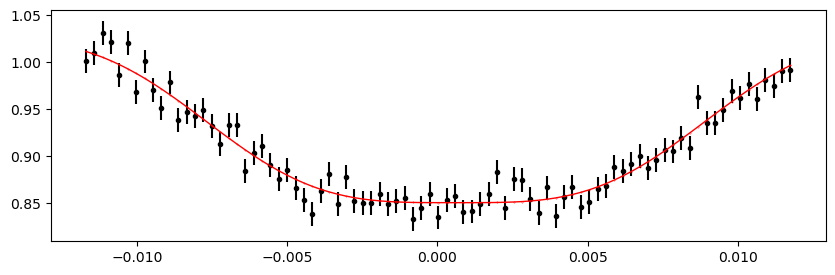

2858.9613600000002 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.88it/s]


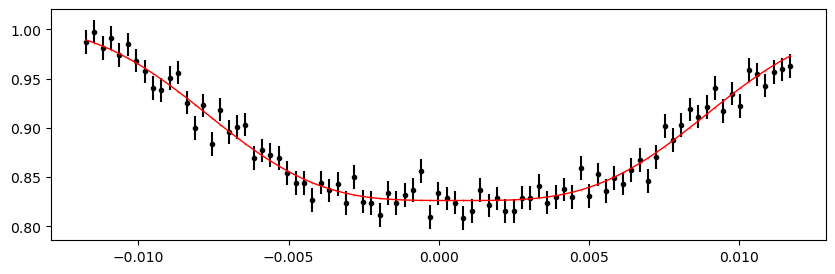

2867.25108 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.27it/s]


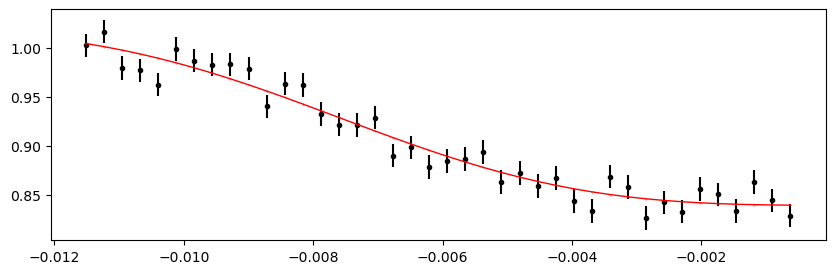

2875.5408 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 387.37it/s]


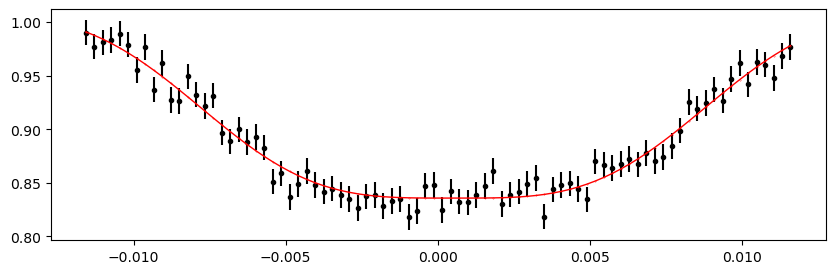

2883.8305200000004 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.75it/s]


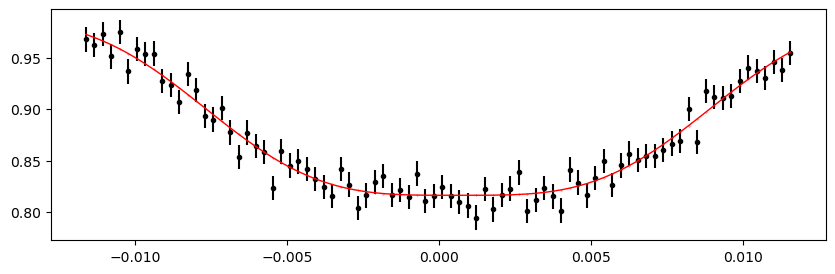

2892.12024 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.72it/s]


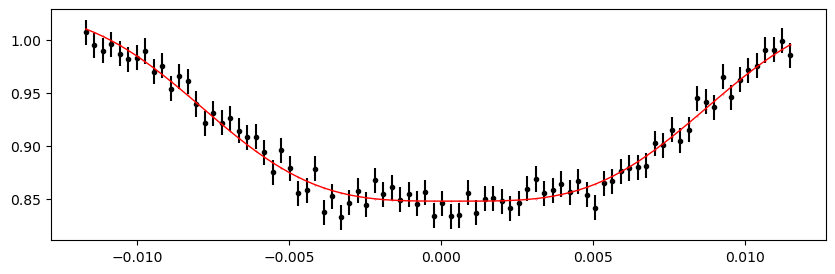

2900.40996 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 381.35it/s]


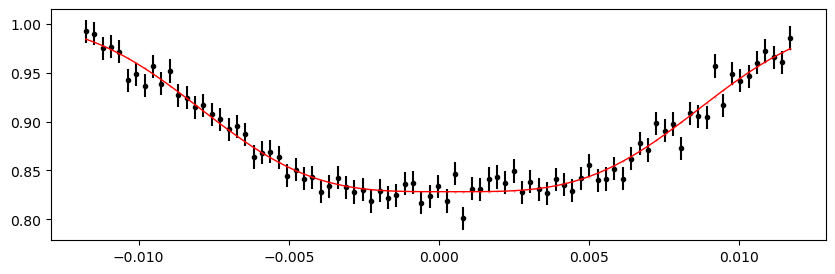

2908.69968 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.68it/s]


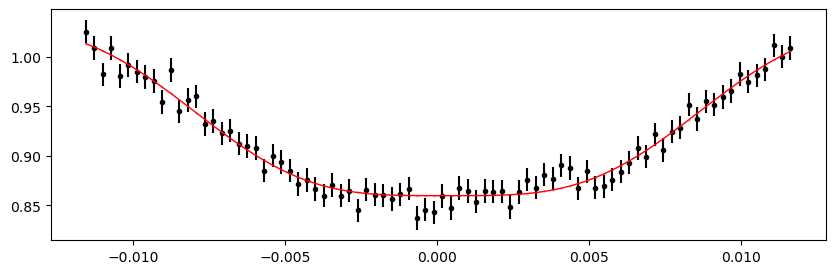

3372.924 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.78it/s]


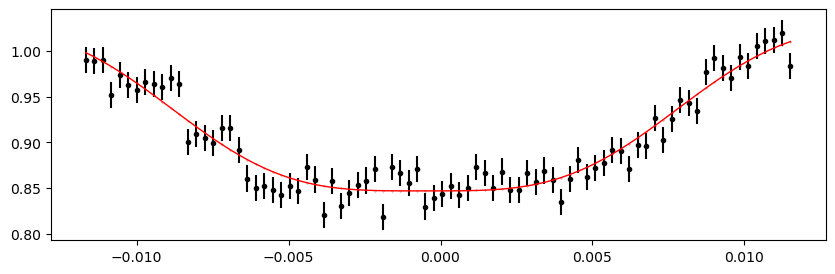

3381.21372 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.92it/s]


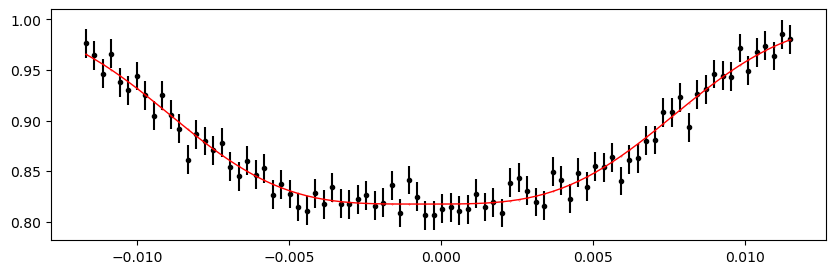

3389.5034400000004 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 385.27it/s]


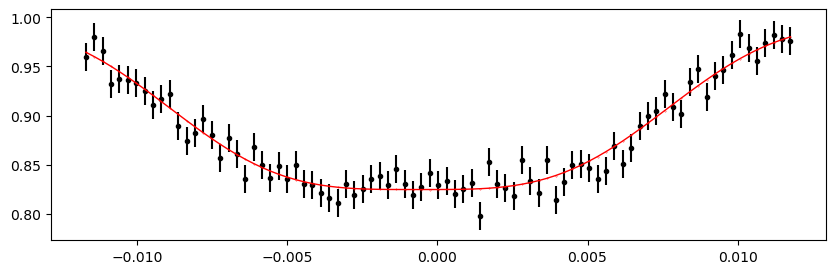

3397.79316 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.65it/s]


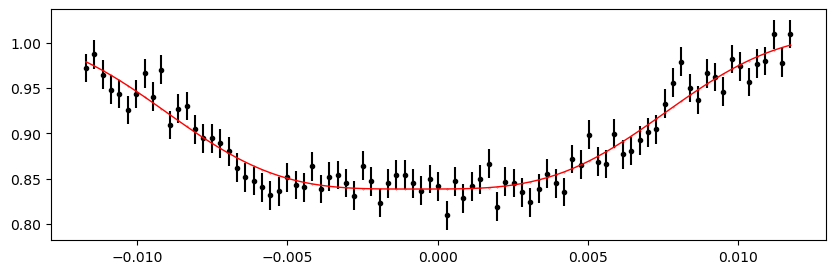

3406.08288 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 391.16it/s]


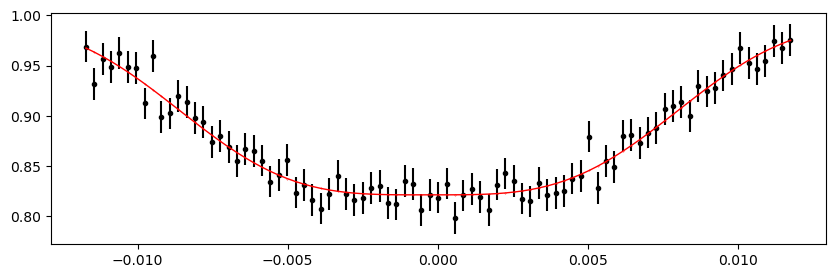

3422.6623200000004 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.97it/s]


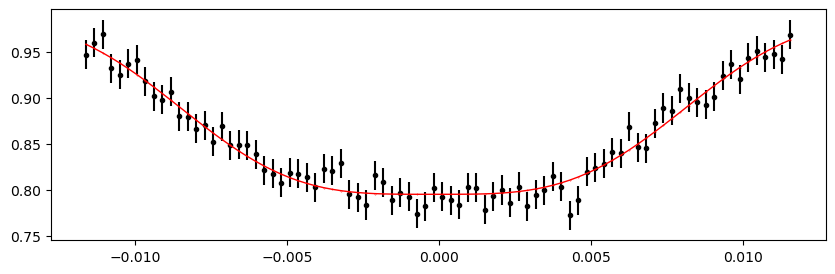

3439.24176 1.0142945653741924 -0.170343242318729 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.78it/s]


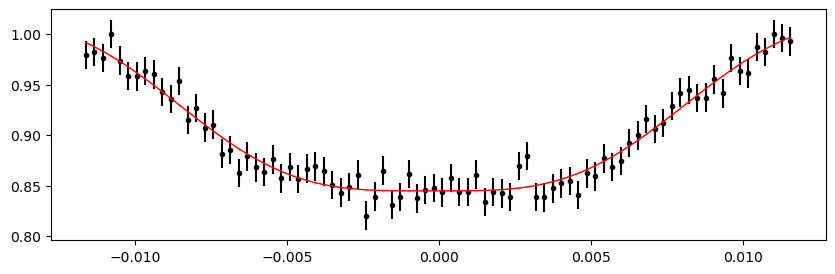

In [56]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=8,  # accomodate 30 min cadence data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"


Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
1727.49972 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 537.99it/s]


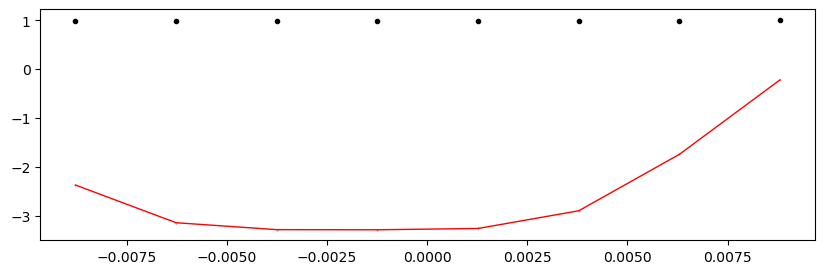

1735.78944 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 538.22it/s]


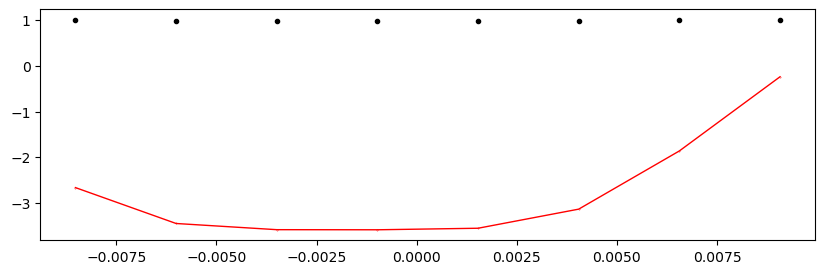

1744.07916 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 524.55it/s]


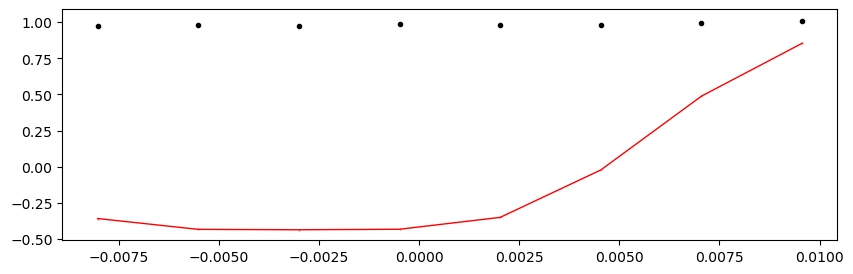

1752.36888 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 536.01it/s]


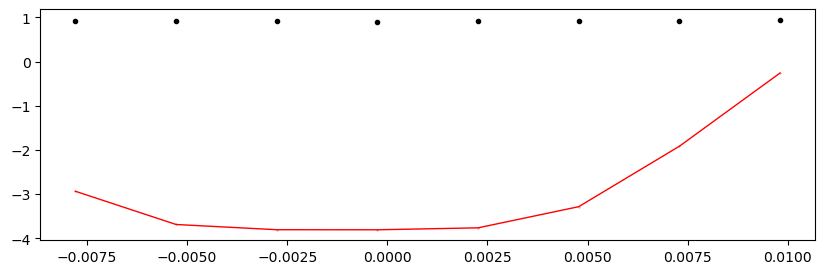

1760.6586 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 525.83it/s]


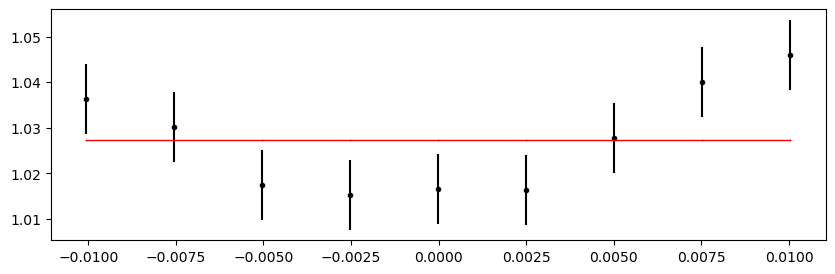

1768.94832 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.81it/s]


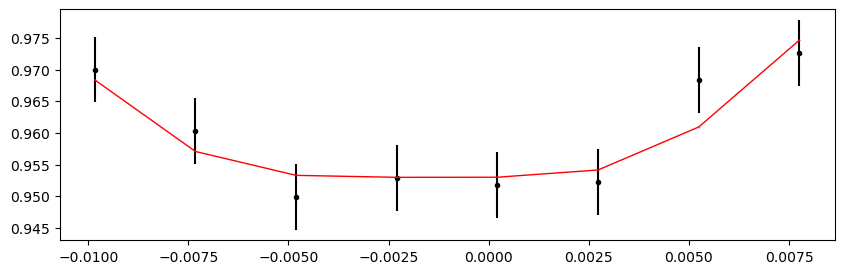

1785.52776 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 539.08it/s]


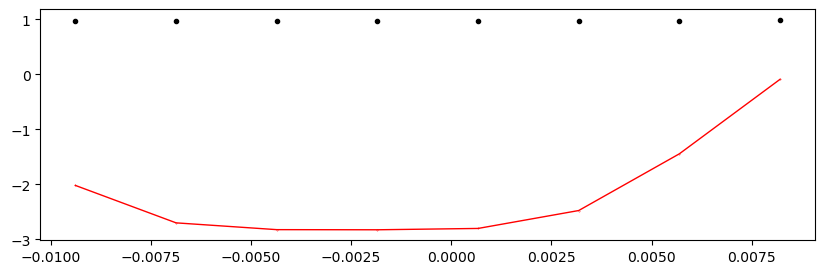

1959.6118800000002 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.23it/s]


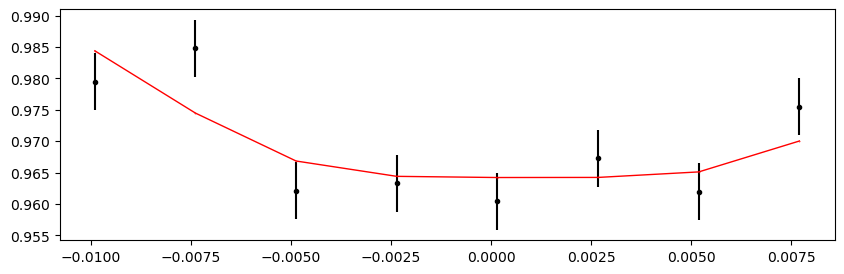

1967.9016000000001 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:17<00:00, 561.87it/s]


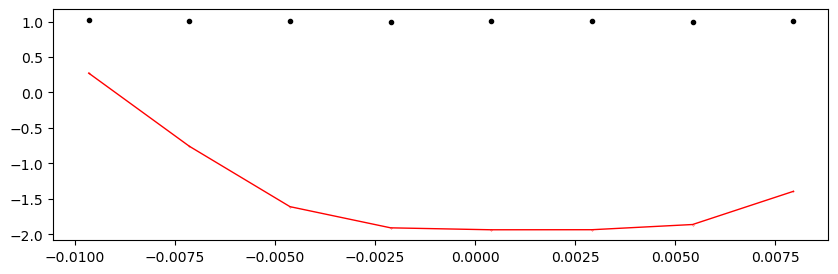

1976.1913200000001 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 536.71it/s]


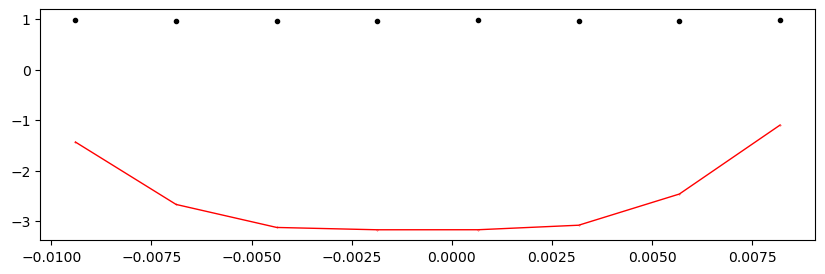

2830.03248 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.70it/s]


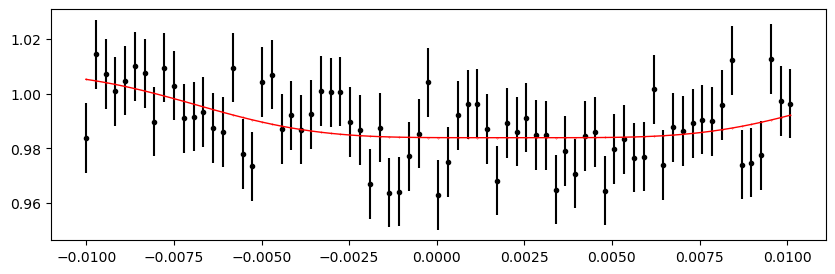

2838.3222 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 353.72it/s]


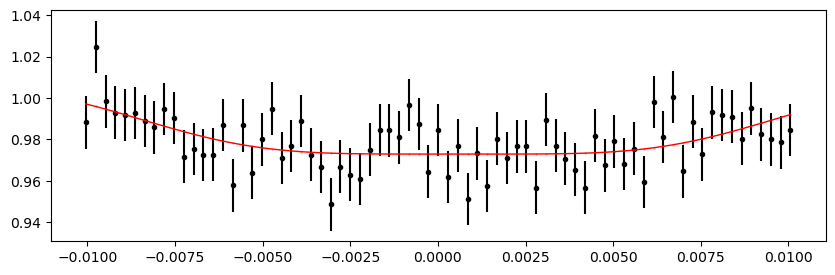

2846.6119200000003 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.98it/s]


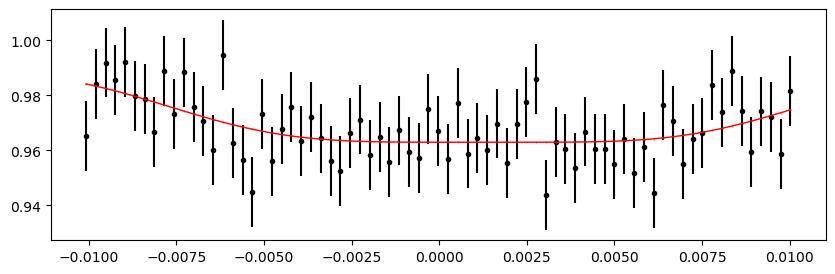

2854.90164 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 402.50it/s]


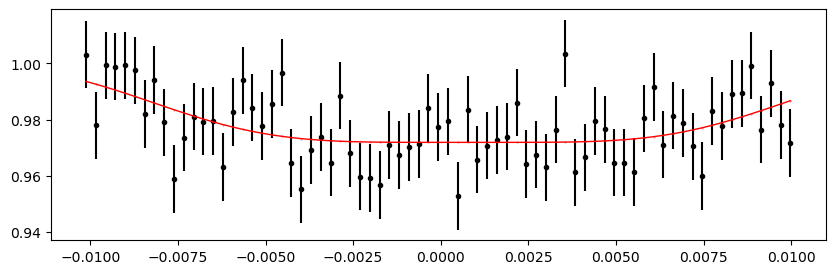

2863.1913600000003 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 396.26it/s]


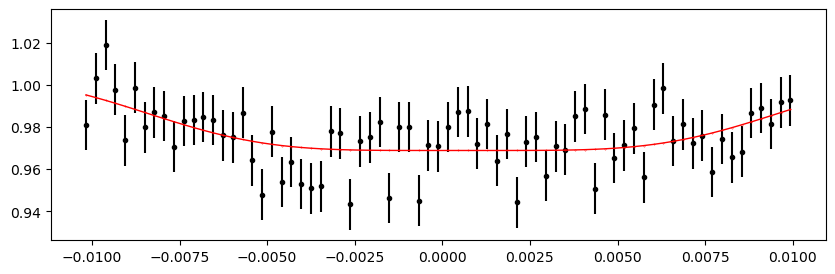

2871.4810800000005 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 399.46it/s]


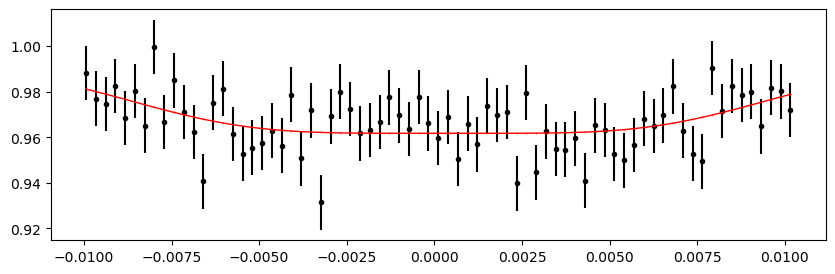

2879.7708000000002 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 497.60it/s]


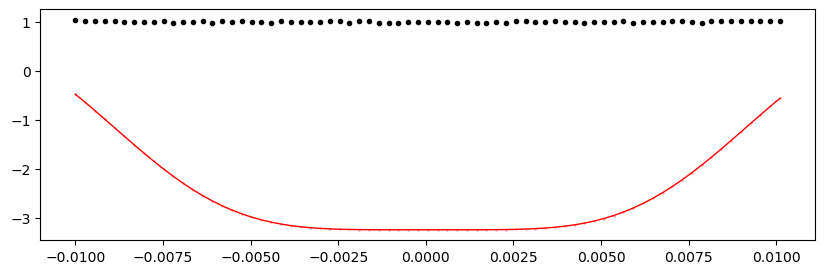

2888.06052 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.03it/s]


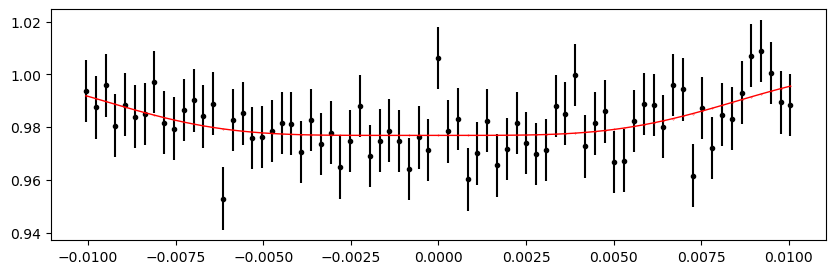

2896.35024 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 487.38it/s]


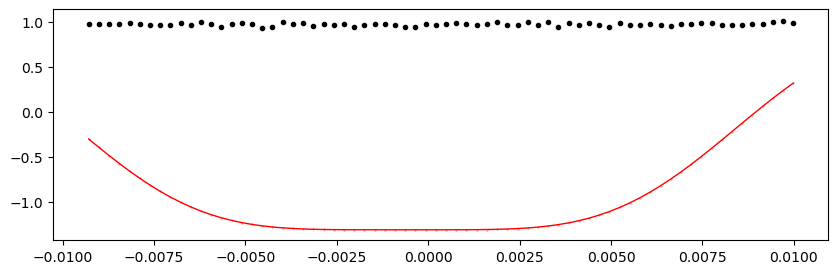

2904.6399600000004 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 397.72it/s]


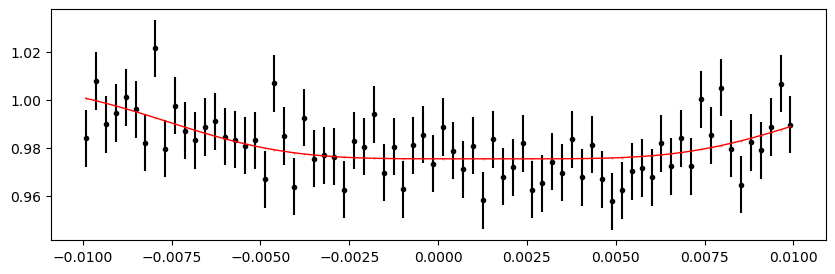

3368.8642800000002 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 481.54it/s]


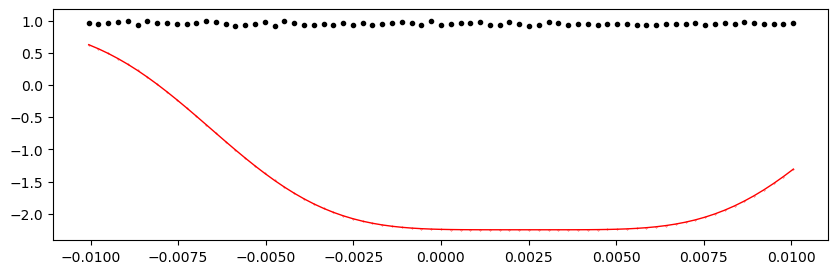

3377.1540000000005 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 393.59it/s]


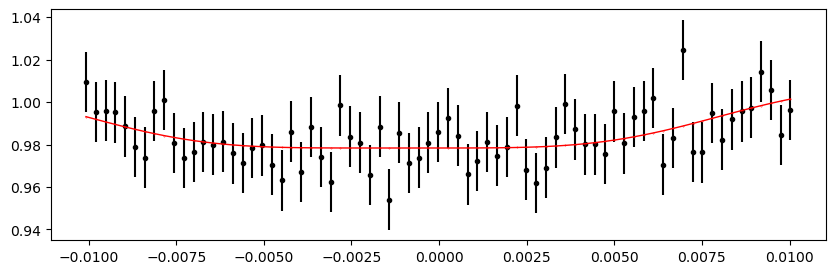

3385.44372 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.23it/s]


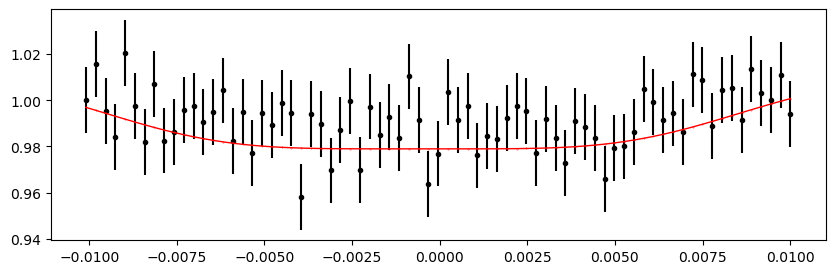

3393.73344 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 392.12it/s]


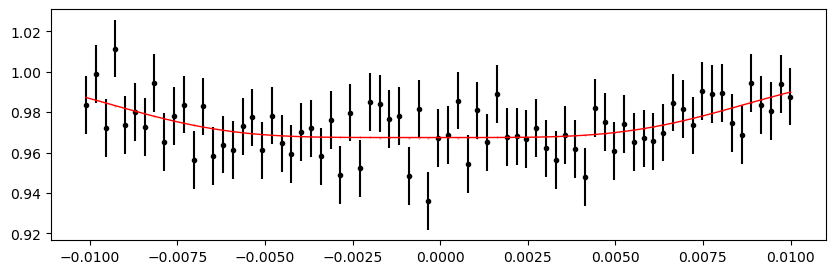

3402.02316 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 398.98it/s]


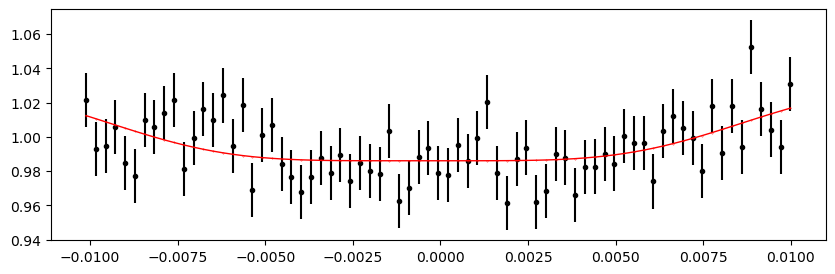

3418.6026 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 499.51it/s]


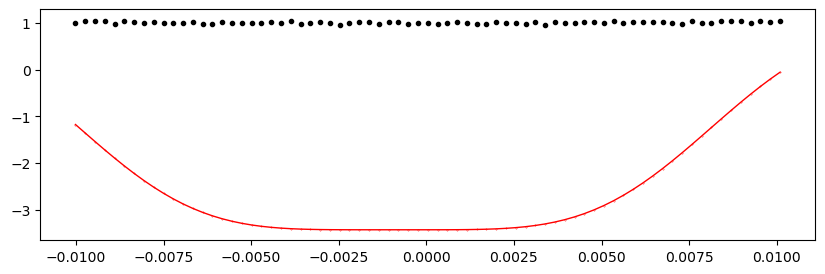

3435.18204 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 496.42it/s]


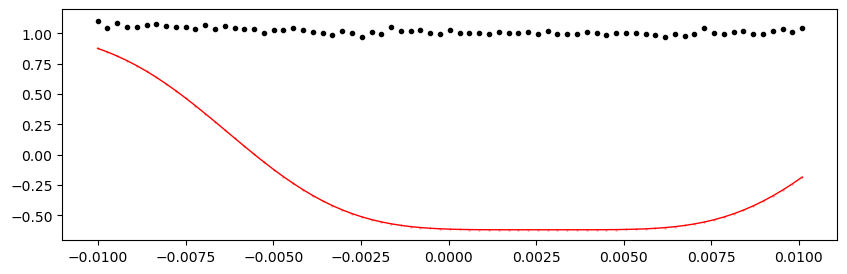

3443.4717600000004 1.0102247011915213 -0.034652007569601476 0


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 395.51it/s]


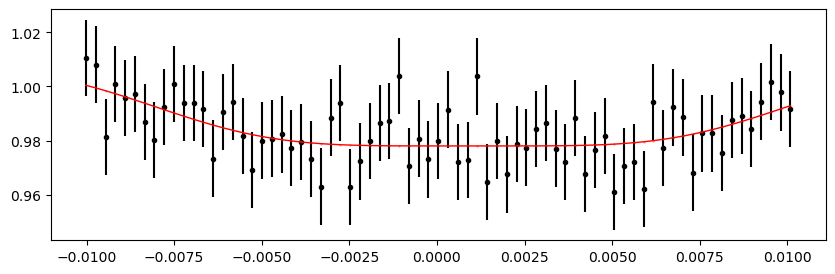

In [57]:
# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=7,  # accomodate 30 min cadence data
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

## ETV O-C plot

Note: 2 data points in df_primary filtered out due to huge O-C error.
Note: 21 data points in in_df_secondary filtered out due to huge O-C error.


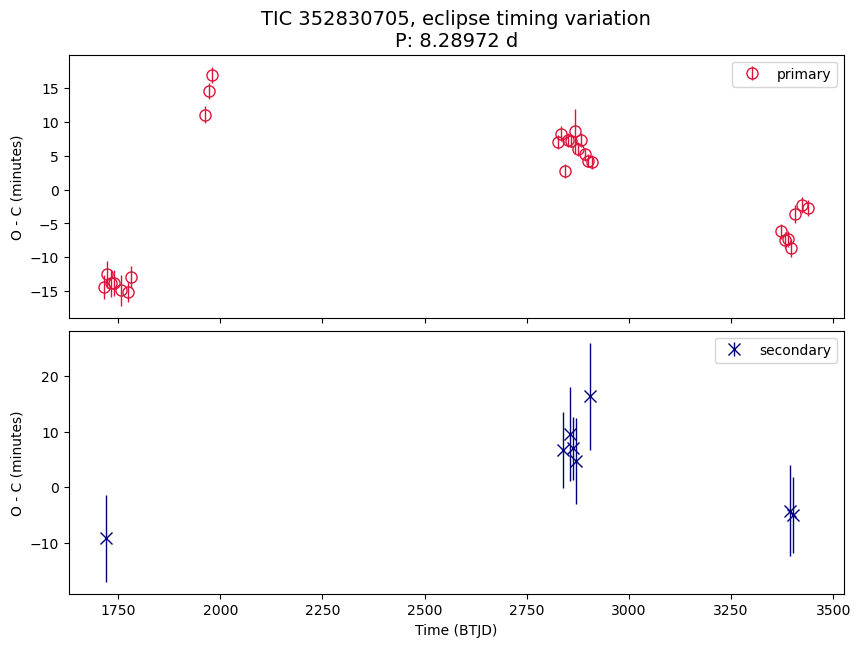

In [62]:
%matplotlib inline
# %matplotlib widget


title_suffix = "eclipse timing variation"

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary_all = in_df_primary  # in case filtering is helpful

in_df_primary = in_df_primary[in_df_primary.std_mins < 10]  # filter out outliers in error
print(f"Note: {len(in_df_primary_all) - len(in_df_primary)} data points in df_primary filtered out due to huge O-C error.")

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'],
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary_all = in_df_secondary  # in case filtering is helpful

    in_df_secondary = in_df_secondary[in_df_secondary.std_mins < 10]  # filter out outliers in error
    print(f"Note: {len(in_df_secondary_all) - len(in_df_secondary)} data points in in_df_secondary filtered out due to huge O-C error.")

    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, {title_suffix}\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

In [ ]:
# # to help to filter out valeus with huge error
# ax = in_df_primary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

# ax = in_df_secondary_all.std_mins.hist(bins=100)
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.show()

### O-C Plot, Zoom In

In [ ]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
]

def tweak_axs_list(axs_list):
    # axs_list[0][1].set_ylim(-20, 30);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    # ax = axs_list[0][0]
    # ax.set_title(f"{ax.get_title()} (30min cadence)")
    # ax = axs_list[1][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")

    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5

        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]

        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

        # axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
        #                marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

            # axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
            #                marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
                            lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();

        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)

        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

In [ ]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')

plt.xlabel("period")

plt.legend()
plt.xlim(0, 2500)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))

    plt.plot(1/frequency, power, label = 'primary')

    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')

    plt.xlabel("period")

    plt.legend()
    plt.xlim(0, 500)
    plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))

    plt.plot(1/frequency, power, label = 'primary')

    if t0_secondary is not None:
        plt.plot(1/frequency_s, power_s, label = 'secondary')

    plt.xlabel("period")

    plt.legend()
    plt.xlim(0, 100)
    plt.show()

## O-C plot, folded

- for periodic trend in O-C

In [ ]:
def truncate_freq_power_to_period_range(freq, power, period_min, period_max):
    f, p = freq, power
    if period_min is not None:
        f, p = f[f < 1 / period_min], p[f < 1 / period_min]
    if period_max is not None:
        f, p = f[f > 1 / period_max], p[f >  1 / period_max]
    return f, p


def plot_oc_folded(period_min=None, period_max=None, period_min_s=None, period_max_s=None, period=None, period_s=None):

    if period is None:
        _f, _p = truncate_freq_power_to_period_range(frequency, power, period_min, period_max)
        period = 1 / _f[np.argmax(_p)]
    phase_oc = etv_functions.phase_data(in_df_primary.epoch, 0, period)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y * 1.1), sharex=False)
    if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
        axs = [axs]
    
    axs[0].scatter(phase_oc, in_df_primary.shift_mins, marker = 'o', s=12**2, c=in_df_primary.epoch);
    axs[0].errorbar(phase_oc, in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'],
                    lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'None', label="primary")
    axs[0].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period:.4f} d", fontsize=14)

    if in_df_secondary is not None:
        if period_s is None:
            _f, _p = truncate_freq_power_to_period_range(frequency_s, power_s, period_min_s, period_max_s)
            period_s= 1 / _f[np.argmax(_p)]
        phase_oc_s = etv_functions.phase_data(in_df_secondary.epoch, 0, period_s)
        axs[1].scatter(phase_oc_s, in_df_secondary.shift_mins, marker = 'o',  s=12**2, c=in_df_secondary.epoch);
        axs[1].errorbar(phase_oc_s, in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'],
                        lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color='None', ecolor='navy', markeredgecolor = 'None', label="secondary" );
        axs[1].set_title(f"TIC {ticid}, {title_suffix}\nfolded with P={period_s:.4f} d", fontsize=14)

    for ax in axs:
        ax.set_ylabel("O - C (minutes)")
        ax.set_xlabel("Phase (Normalized)")
        ax.legend();
    plt.subplots_adjust(hspace=0.4)
    return axs

In [ ]:
%matplotlib inline
# %matplotlib widget

if True:  # plot O-C periodic trend by folding with a period (from LS Periodogram by default)
    def tweak_axs(axs):
        pass

    axs = plot_oc_folded(
        period_min=None, period_max=None,
        period_min_s=None, period_max_s=None
    )

    axs = plot_oc_folded(
        period_min=None, period_max=50,
        period_min_s=None, period_max_s=None
    )

    axs = plot_oc_folded(
        period_min=60, period_max=None,
        period_min_s=None, period_max_s=None
    )
    
    # tweak_axs(axs)

## Results Summary

In [ ]:
# FILL-IN the ETV results / comments
has_etv = "Y"
comments = "O-C suggests long-linear trend for both primary and secondary. [D*0.9]"

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True,
))